# National Phenology Network Data Visualization

The National Phenology Network maintains a rich repository of phenology observations across the US

(https://www.usanpn.org/home)

They maintain a full set of web based data access and visualization tools but what if you need a different visualiztion or want to integrate these data into your own modeling or scientific efforts?  This notebook provides an example of how that might be accomplished using Python.  A similar process could be done in R (see: rnpn package on cran) or your language of choice.

In [1]:
#Standard inports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xml.etree.ElementTree as ET
import datetime
import pandas as pd
import requests
import getpass

### A service call to the NPN returns a Pandas data frame of the available species

In [2]:
url = "http://www.usanpn.org/npn_portal/species/getSpecies.xml"
response = requests.get(url)

parsed = ET.fromstring(response.content)
species = pd.DataFrame([item.attrib for item in parsed.findall('spec')])

species.head(5)

,common_name,functional_type,genus,itis_taxonomic_sn,species,species_id
0,'ohi'a lehua,Evergreen broadleaf,Metrosideros,27259,polymorpha,120
1,absinthium,Forb,Artemisia,35445,absinthium,1436
2,Acadian flycatcher,Bird,Empidonax,178339,virescens,1227
3,acorn woodpecker,Bird,Melanerpes,178189,formicivorus,1229
4,alderleaf mountain-mahogany,Semi-evergreen broadleaf,Cercocarpus,25136,montanus,1343


#### This can be queried to get info on specific species

In [3]:
species[species.common_name.str.contains('Monarch', case=False)]

,common_name,functional_type,genus,itis_taxonomic_sn,species,species_id
621,monarch,Insect,Danaus,117273,plexippus,396


### Define a function to pull all the observations for a given species

In [4]:
def get_all_obs(species_id, start_dt=None, end_dt=None):
    
    if not start_dt:
        start_dt = datetime.datetime(1900, 1, 1)
        
    if not end_dt:
        end_dt = datetime.datetime.now()
    
    start_date = "{}-{:02d}-{:02d}".format(start_dt.year, start_dt.month, start_dt.day)
    end_date = "{}-{:02d}-{:02d}".format(end_dt.year, end_dt.month, end_dt.day)
    
    species_id=str(species_id)
    
    request_src = getpass.getuser() + 'Exploring'
#     phenophase_id="483"
    baseurl="http://www.usanpn.org/npn_portal/observations/getObservations.xml?"
    XMLq = "".join([baseurl,"start_date=",start_date,"&end_date=",end_date,"&species_id=",species_id,
#                     "&phenophase_id=",phenophase_id,
                    "&request_src=", request_src])

    response = requests.get(XMLq)
    
    parsed = ET.fromstring(response.content)
    df = pd.DataFrame([item.attrib for item in parsed.findall('observation')], dtype=float)
    df.observation_date = pd.to_datetime(df.observation_date, format='%Y-%m-%d')
    return df

In [5]:
#3 is the species id for red oak
red_oak = get_all_obs(3)

In [6]:
red_oak.head(5)

,abundance_value,common_name,day_of_year,elevation_in_meters,genus,individual_id,intensity_category_id,intensity_value,kingdom,latitude,...,observation_date,observation_id,phenophase_description,phenophase_id,phenophase_status,site_id,species,species_id,state,update_datetime
0,-9999.0,red maple,77.0,12.0,Acer,9.0,-9999.0,-9999,Plantae,43.08535,...,2009-03-18,163204.0,>=75% of full leaf size (deciduous),180.0,0.0,2.0,rubrum,3.0,ME,-9999
1,-9999.0,red maple,84.0,12.0,Acer,9.0,-9999.0,-9999,Plantae,43.08535,...,2009-03-25,163194.0,>=75% of full leaf size (deciduous),180.0,0.0,2.0,rubrum,3.0,ME,-9999
2,-9999.0,red maple,90.0,12.0,Acer,9.0,-9999.0,-9999,Plantae,43.08535,...,2009-03-31,171385.0,>=75% of full leaf size (deciduous),180.0,0.0,2.0,rubrum,3.0,ME,-9999
3,-9999.0,red maple,94.0,12.0,Acer,9.0,-9999.0,-9999,Plantae,43.08535,...,2009-04-04,171375.0,>=75% of full leaf size (deciduous),180.0,0.0,2.0,rubrum,3.0,ME,-9999
4,-9999.0,red maple,99.0,12.0,Acer,9.0,-9999.0,-9999,Plantae,43.08535,...,2009-04-09,171365.0,>=75% of full leaf size (deciduous),180.0,0.0,2.0,rubrum,3.0,ME,-9999


### Some exploratory data visualization examples

In [7]:
def rand_jitter(arr):
    stdev = .25
    return arr + np.random.randn(len(arr)) * stdev

def jitter(ax, x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, **kwargs):
    return ax.scatter(x, rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, 
                      vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts, **kwargs)

In [8]:
red_oak.shape

(488339, 21)

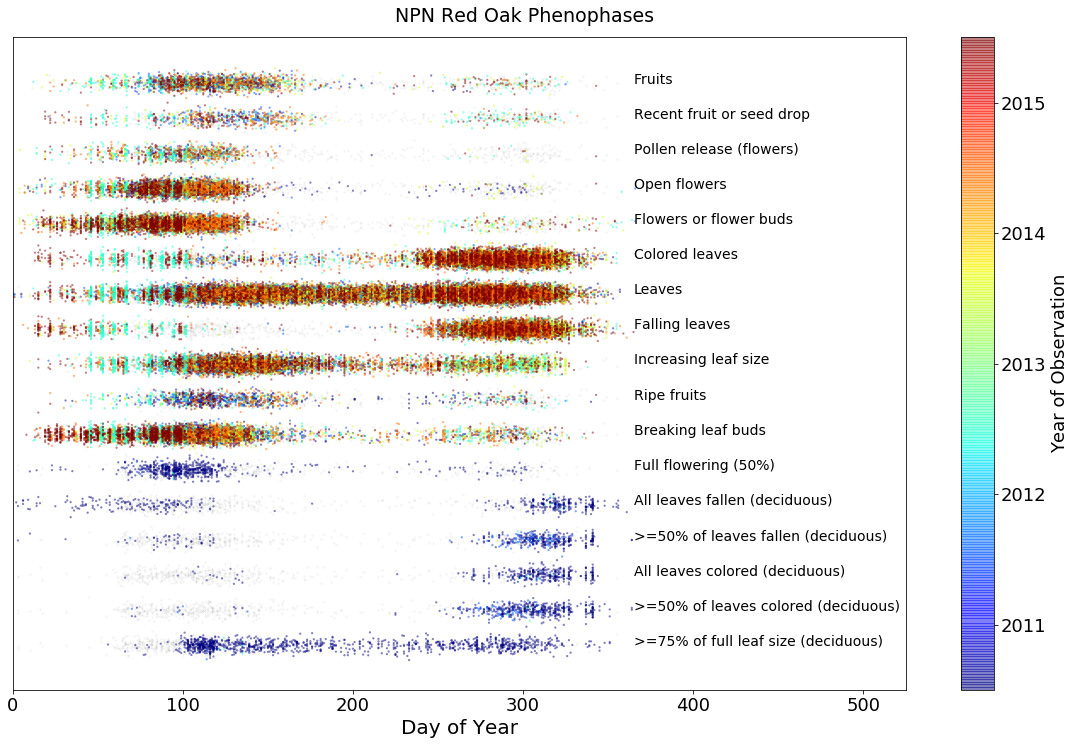

In [9]:
%matplotlib inline
fig, ax = plt.subplots(1, figsize=(20,12))

for i, phenophase in enumerate(red_oak.phenophase_description.unique()):
    this_data = red_oak.query('phenophase_description=="{}" & phenophase_status==0'.format(phenophase)).head(500)
    xs = np.zeros(this_data.day_of_year.shape)
    xs[:] = i*2
    jitter(ax, this_data.day_of_year, xs, c='grey', alpha=0.1, lw=0, s=5)


    this_data = red_oak.query('phenophase_description=="{}" & phenophase_status==1'.format(phenophase))
    xs = np.zeros(this_data.day_of_year.shape)
    xs[:] = i*2
    mappable = jitter(ax, this_data.day_of_year, xs, alpha=0.5, s= 5, lw=0, c=[o.year for o in this_data.observation_date], 
                      cmap='jet', vmin=2011, vmax=2016)

    ax.text(365, i*2, phenophase, fontdict=dict(size=14))
    
ax.yaxis.set_major_locator(plt.NullLocator())
fig.suptitle = ""
ax.text(225, 35.5, 'NPN Red Oak Phenophases', fontdict=dict(size=19))

ax.set_xlim(0, 525)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18)
ax.set_xlabel('Day of Year', size=20)


cb = plt.colorbar(mappable)
labels = np.arange(2011, 2018, 1)
loc = labels + .5
cb.set_ticks(loc)
cb.set_ticklabels(labels)
cb.ax.tick_params(labelsize=18)
text = cb.set_label("Year of Observation", size=18)

In [10]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_inset(ax, point_data):
    
#     
    ax.set_extent([-123, -67, 20, 52], ccrs.Geodetic())

#     ax.stock_img()

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.LAKES)

    return ax.scatter(point_data.longitude, point_data.latitude, c=point_data.latitude, 
               lw=0, transform=ccrs.Geodetic(), zorder=2, vmin=lat_min, vmax=lat_max, cmap='jet')
    
# ax = plt.axes([0, 0, 1, 1],
#                       projection=ccrs.LambertConformal())
# plot_inset(ax)
# plt.colorbar()

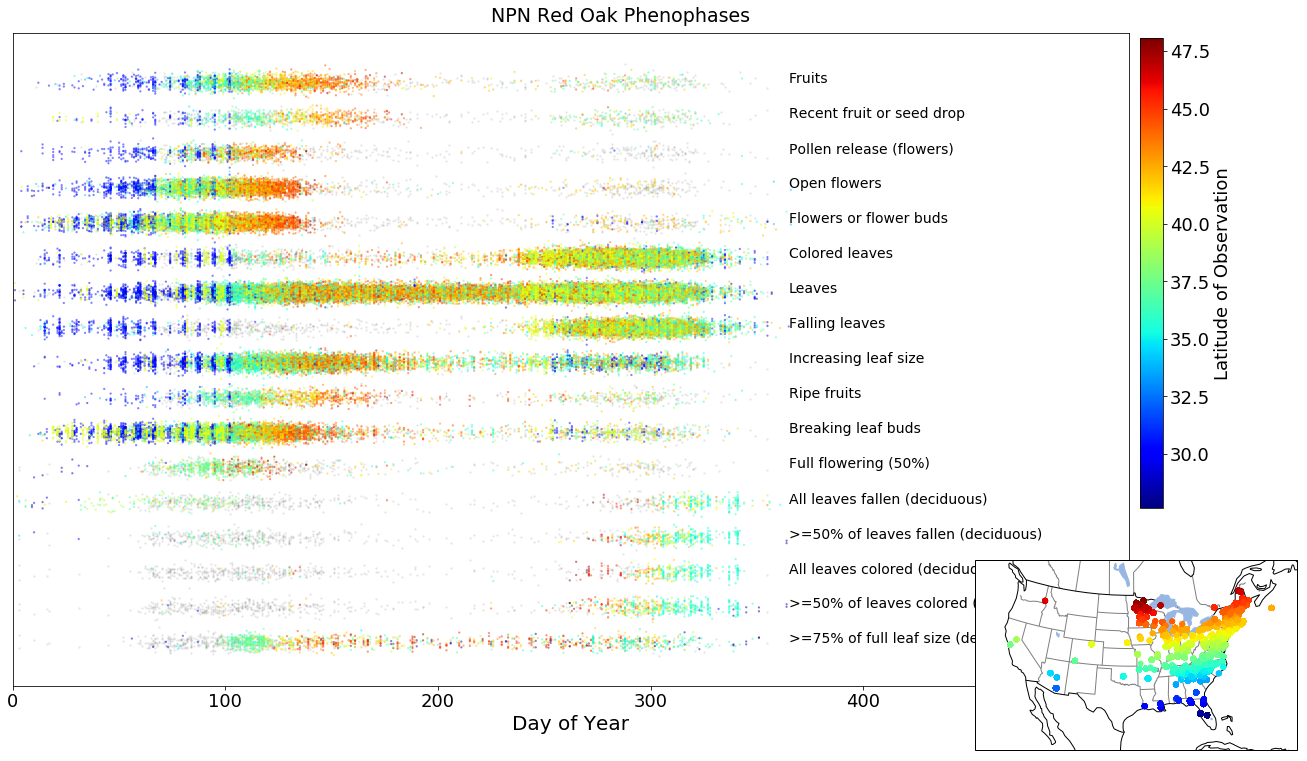

In [11]:
fig, ax = plt.subplots(1, figsize=(20,12))

lower_data = red_oak.query('latitude<50')
lat_min = lower_data.latitude.min()
lat_max = lower_data.latitude.max()

for i, phenophase in enumerate(red_oak.phenophase_description.unique()):
    this_data = red_oak.query('phenophase_description=="{}" & phenophase_status==0 & latitude<50'.format(phenophase)).head(500)
    xs = np.zeros(this_data.day_of_year.shape)
    xs[:] = i*2
    jitter(ax, this_data.day_of_year, xs, c='k', alpha=0.1, lw=0, s=5)


    this_data = red_oak.query('phenophase_description=="{}" & phenophase_status==1 & latitude<50'.format(phenophase))
    xs = np.zeros(this_data.day_of_year.shape)
    xs[:] = i*2
    mappable = jitter(ax, this_data.day_of_year, xs, alpha=0.5, s= 5, lw=0, c=this_data.latitude, 
                      cmap='jet', vmin=lat_min, vmax=lat_max)

    ax.text(365, i*2, phenophase, fontdict=dict(size=14))
    
ax.yaxis.set_major_locator(plt.NullLocator())
fig.suptitle = ""
ax.text(225, 35.5, 'NPN Red Oak Phenophases', fontdict=dict(size=19))

ax.set_xlim(0, 525)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18)
ax.set_xlabel('Day of Year', size=20)

cax = inset_axes(ax,
                 width="2%",
                 height="80%",
                 bbox_transform=ax.transAxes,
                 bbox_to_anchor=(0.025, 0.1, 1.01, .90),
                 loc= 1)


sub_ax = plt.axes([0.78, 0.05, 0.25, 0.22], projection=ccrs.LambertConformal())
mappable = plot_inset(sub_ax, red_oak)
cb = fig.colorbar(mappable, cax=cax)
cb.ax.tick_params(labelsize=18)
text = cb.set_label("Latitude of Observation", size=18)

In [12]:
monarch = get_all_obs(396)
monarch.head(3)

,abundance_value,common_name,day_of_year,elevation_in_meters,genus,individual_id,intensity_category_id,intensity_value,kingdom,latitude,...,observation_date,observation_id,phenophase_description,phenophase_id,phenophase_status,site_id,species,species_id,state,update_datetime
0,-9999.0,monarch,115.0,163.0,Danaus,12056.0,-9999.0,-9999.0,Animalia,43.040955,...,2011-04-25,472117.0,Dead adults,289.0,0.0,6.0,plexippus,396.0,NY,-9999
1,-9999.0,monarch,118.0,163.0,Danaus,12056.0,-9999.0,-9999.0,Animalia,43.040955,...,2011-04-28,478232.0,Dead adults,289.0,0.0,6.0,plexippus,396.0,NY,-9999
2,-9999.0,monarch,122.0,163.0,Danaus,12056.0,-9999.0,-9999.0,Animalia,43.040955,...,2011-05-02,492582.0,Dead adults,289.0,0.0,6.0,plexippus,396.0,NY,-9999


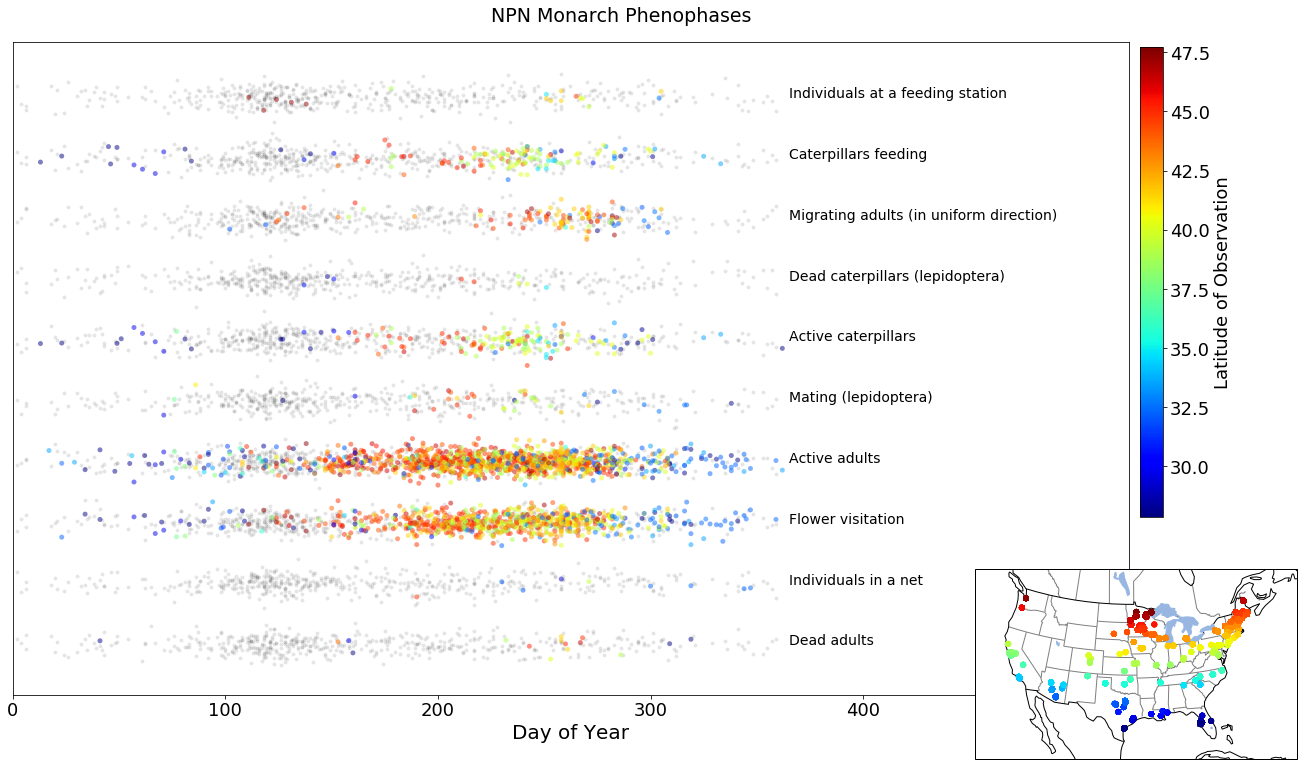

In [13]:
fig, ax = plt.subplots(1, figsize=(20,12))

plot_data = monarch

lower_data = plot_data.query('latitude<50')
lat_min = lower_data.latitude.min()
lat_max = lower_data.latitude.max()

for i, phenophase in enumerate(plot_data.phenophase_description.unique()):
    this_data = plot_data.query('phenophase_description=="{}" & phenophase_status==0 & latitude<50'.format(phenophase)).head(500)
    xs = np.zeros(this_data.day_of_year.shape)
    xs[:] = i*2
    jitter(ax, this_data.day_of_year, xs, c='k', alpha=0.1, lw=0, s=15)


    this_data = plot_data.query('phenophase_description=="{}" & phenophase_status==1 & latitude<50'.format(phenophase))
    xs = np.zeros(this_data.day_of_year.shape)
    xs[:] = i*2
    mappable = jitter(ax, this_data.day_of_year, xs, alpha=0.5, s= 25, lw=0, c=this_data.latitude, 
                      cmap='jet', vmin=lat_min, vmax=lat_max)

    ax.text(365, i*2, phenophase, fontdict=dict(size=14))
    
ax.yaxis.set_major_locator(plt.NullLocator())
fig.suptitle = ""
ax.text(225, (i*2)+2.5, 'NPN Monarch Phenophases', fontdict=dict(size=19))

ax.set_xlim(0, 525)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18)
ax.set_xlabel('Day of Year', size=20)

cax = inset_axes(ax,
                 width="2%",
                 height="80%",
                 bbox_transform=ax.transAxes,
                 bbox_to_anchor=(0.025, 0.1, 1.01, .90),
                 loc= 1)


sub_ax = plt.axes([0.78, 0.05, 0.25, 0.22], projection=ccrs.LambertConformal())
mappable = plot_inset(sub_ax, plot_data)
cb = fig.colorbar(mappable, cax=cax)
cb.ax.tick_params(labelsize=18)
text = cb.set_label("Latitude of Observation", size=18)